![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Visualize water fluxes for the relevant basins. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr 
import shxarray
import numpy as np
import matplotlib.pyplot as plt
import math
from common.config import read_config

In [3]:
conf=read_config()
datadir=conf["dataroot"]

In [4]:
p_et=os.path.join(datadir,conf["ncp-et"])
ds_flux=xr.open_dataset(p_et)
ds_flux=ds_flux.where(ds_flux.valid_time<np.datetime64("2024-05-01T06:00:00.000000000"),drop=True)
display(ds_flux)

dsbasinav=os.path.join(datadir,conf["dsdt"])
dsdtbasinav=xr.open_dataset(dsbasinav)
display(dsdtbasinav)

# dsbasinav=os.path.join(datadir,conf["ncbasav"])
# dsbasinav=xr.open_dataset(dsbasinav)
# display(dsbasinav)

<xarray.Dataset> Size: 528kB
Dimensions:     (basin: 124, valid_time: 253)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2024-...
    expver      (valid_time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001'
  * basin       (basin) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
    basin_area  (basin) float64 992B ...
Data variables:
    avg_ie      (basin, valid_time) float64 251kB -1.593e+03 ... -5.033e+03
    avg_tprate  (basin, valid_time) float64 251kB 315.8 158.0 ... 4.56e+03

<xarray.Dataset> Size: 2MB
Dimensions:          (name: 124, time: 230)
Coordinates:
  * name             (name) <U39 19kB 'SETIT' ... 'TIBETAN PLATEAU'
  * time             (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 2024-0...
Data variables:
    tws_ddk5_vw2016  (name, time) float64 228kB ...
    tws_ddk5_scaled  (name, time) float64 228kB ...
    cntrdiff_vw2016  (name, time) float64 228kB ...
    cntrdiff_scaled  (name, time) float64 228kB ...
    bckdiff_vw2016   (name, time) float64 228kB ...
    bckdiff_scaled   (name, time) float64 228kB ...
    difft_vw2016     (name, time) float64 228kB ...
    difft_scaled     (name, time) float64 228kB ...
    bs_vw2016        (name, time) float64 228kB ...
    bs_scaled        (name, time) float64 228kB ...

In [5]:
time_months=(ds_flux.valid_time-ds_flux.valid_time[0])/np.timedelta64(1,"s")

In [6]:
from scipy import integrate
cumulative_precip=integrate.cumulative_trapezoid(ds_flux.avg_tprate,time_months,dx=1.0,axis=1,initial=None)
cumulative_et=integrate.cumulative_trapezoid(ds_flux.avg_ie,time_months,dx=1.0,axis=1,initial=None)

In [7]:
init_pnt=np.zeros((cumulative_precip.shape[0],1))
cumulative_precip=np.concatenate([init_pnt,cumulative_precip],axis=1) 

cumulative_et=np.concatenate([init_pnt,cumulative_et],axis=1) 

ds_flux["cumulative_precip"]=(("basin","valid_time"),cumulative_precip)
ds_flux["cumulative_et"]=(("basin","valid_time"),cumulative_et)

In [8]:
casestudy_eu=["RHINE","TEJO","GARONNE","PO","Tiber","MARITSA","THAMES","SHANNON","GLOMA","ANGERMAN","TULOMA","DANUBE","NEMAN",
              "DNIEPR","DNIESTR","MARITSA","VELEKA & REZVAYA","VUOKSI","GUDENA"]

casestudy_hof=["SETIT","SHEBELLE","NILE","CONGO","SAHARA/EGYPT","RUFIJI","RIFT","LAKE TURKANA","SAHARA/SUDAN","LAKE CHAD/CHAD & NIGER",
               "LAKE CHAD/CHAD","WEST NILE DELTA","EAST NILE DELTA"]

In [13]:
def plot_waterflux_timeseries(ds_flux,ds_tws,basins):

    ncols=2
    n=len(basins)
    nrows=math.ceil(n/ncols)

    fig,axes=plt.subplots(nrows,ncols,figsize=(15,30))
    axes=axes.flatten()

    for i,basin in enumerate(basins):
        ax=axes[i]

        area=ds_flux.basin_area.sel(basin=basin)
        time=ds_flux.valid_time
        p=ds_flux.avg_tprate.sel(basin=basin)/area
        et=ds_flux.avg_ie.sel(basin=basin)/area

        p_et=(p+et)*1000

        tws=ds_tws.sel(name=basin)
        twsrate=tws.sel(time=time,method="nearest")*1000

        ax.plot(time,p_et,color="darkgreen",linewidth=1.5,label="P - ET")
        ax.plot(time,twsrate,color="royalblue",linestyle="--",linewidth=1.5,label="TWS rate-DDK5-vw2016")
        ax.set_title(basin)
        ax.set_ylabel("mm/sec")
        ax.legend(loc="best")

    [ax.set_axis_off() for ax in axes[n:]]

    plt.tight_layout()


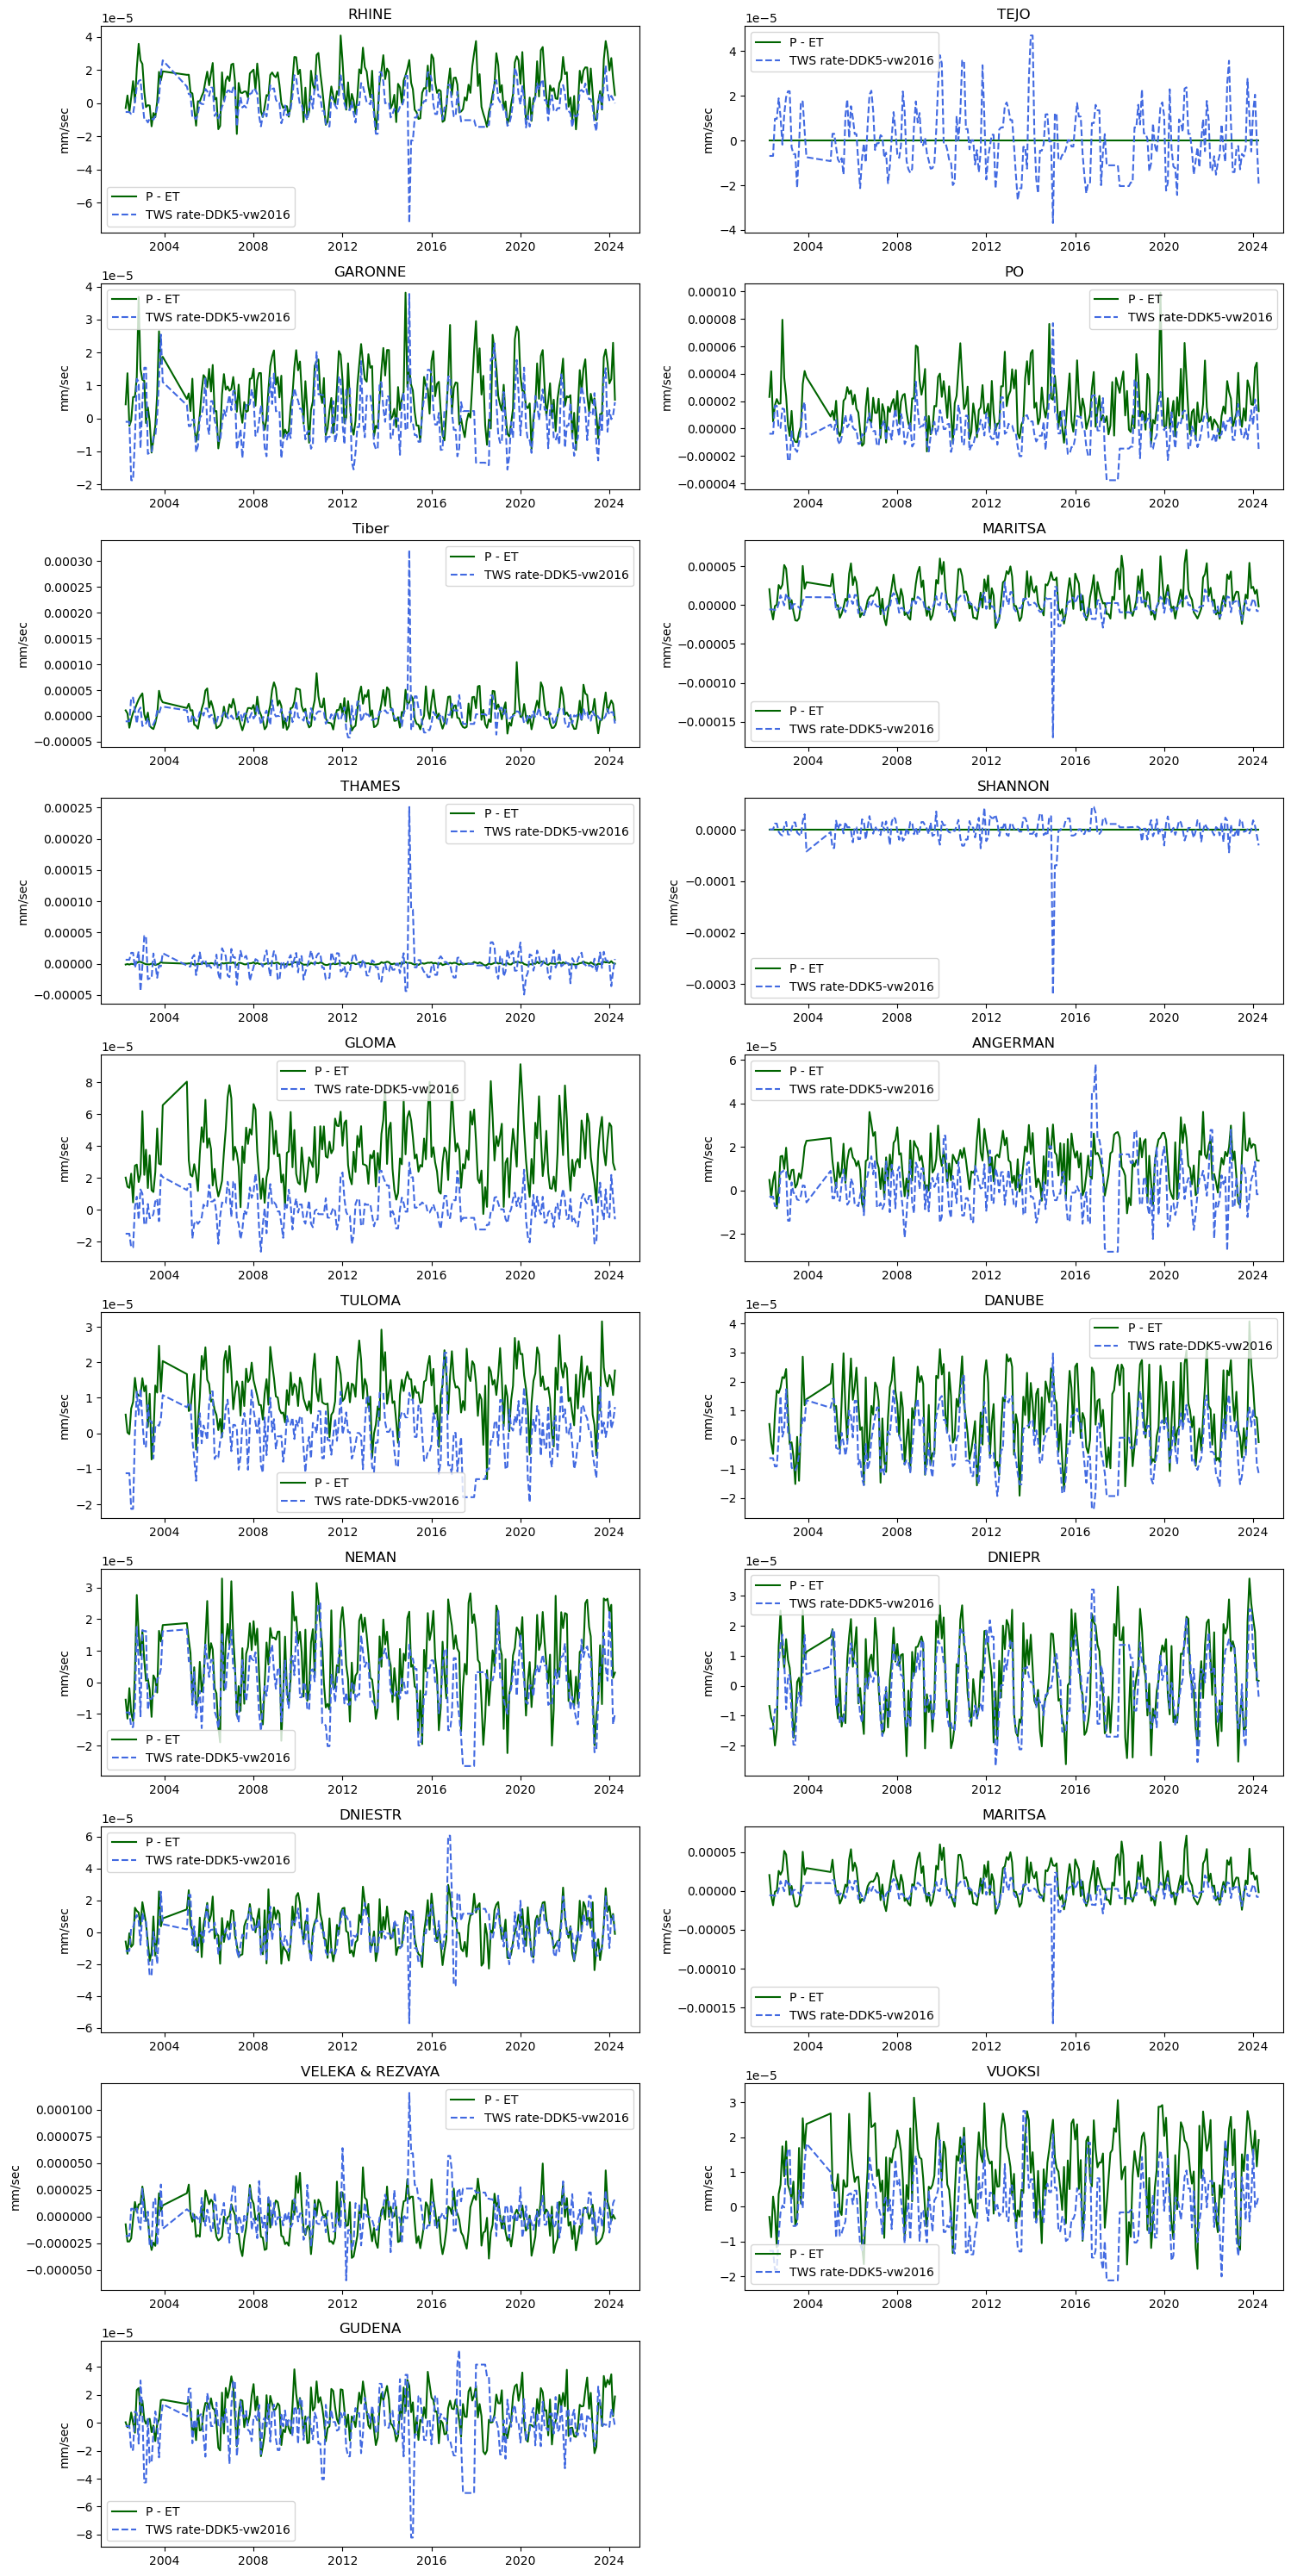

In [14]:
plot_waterflux_timeseries(ds_flux,dsdtbasinav.difft_vw2016,casestudy_eu)

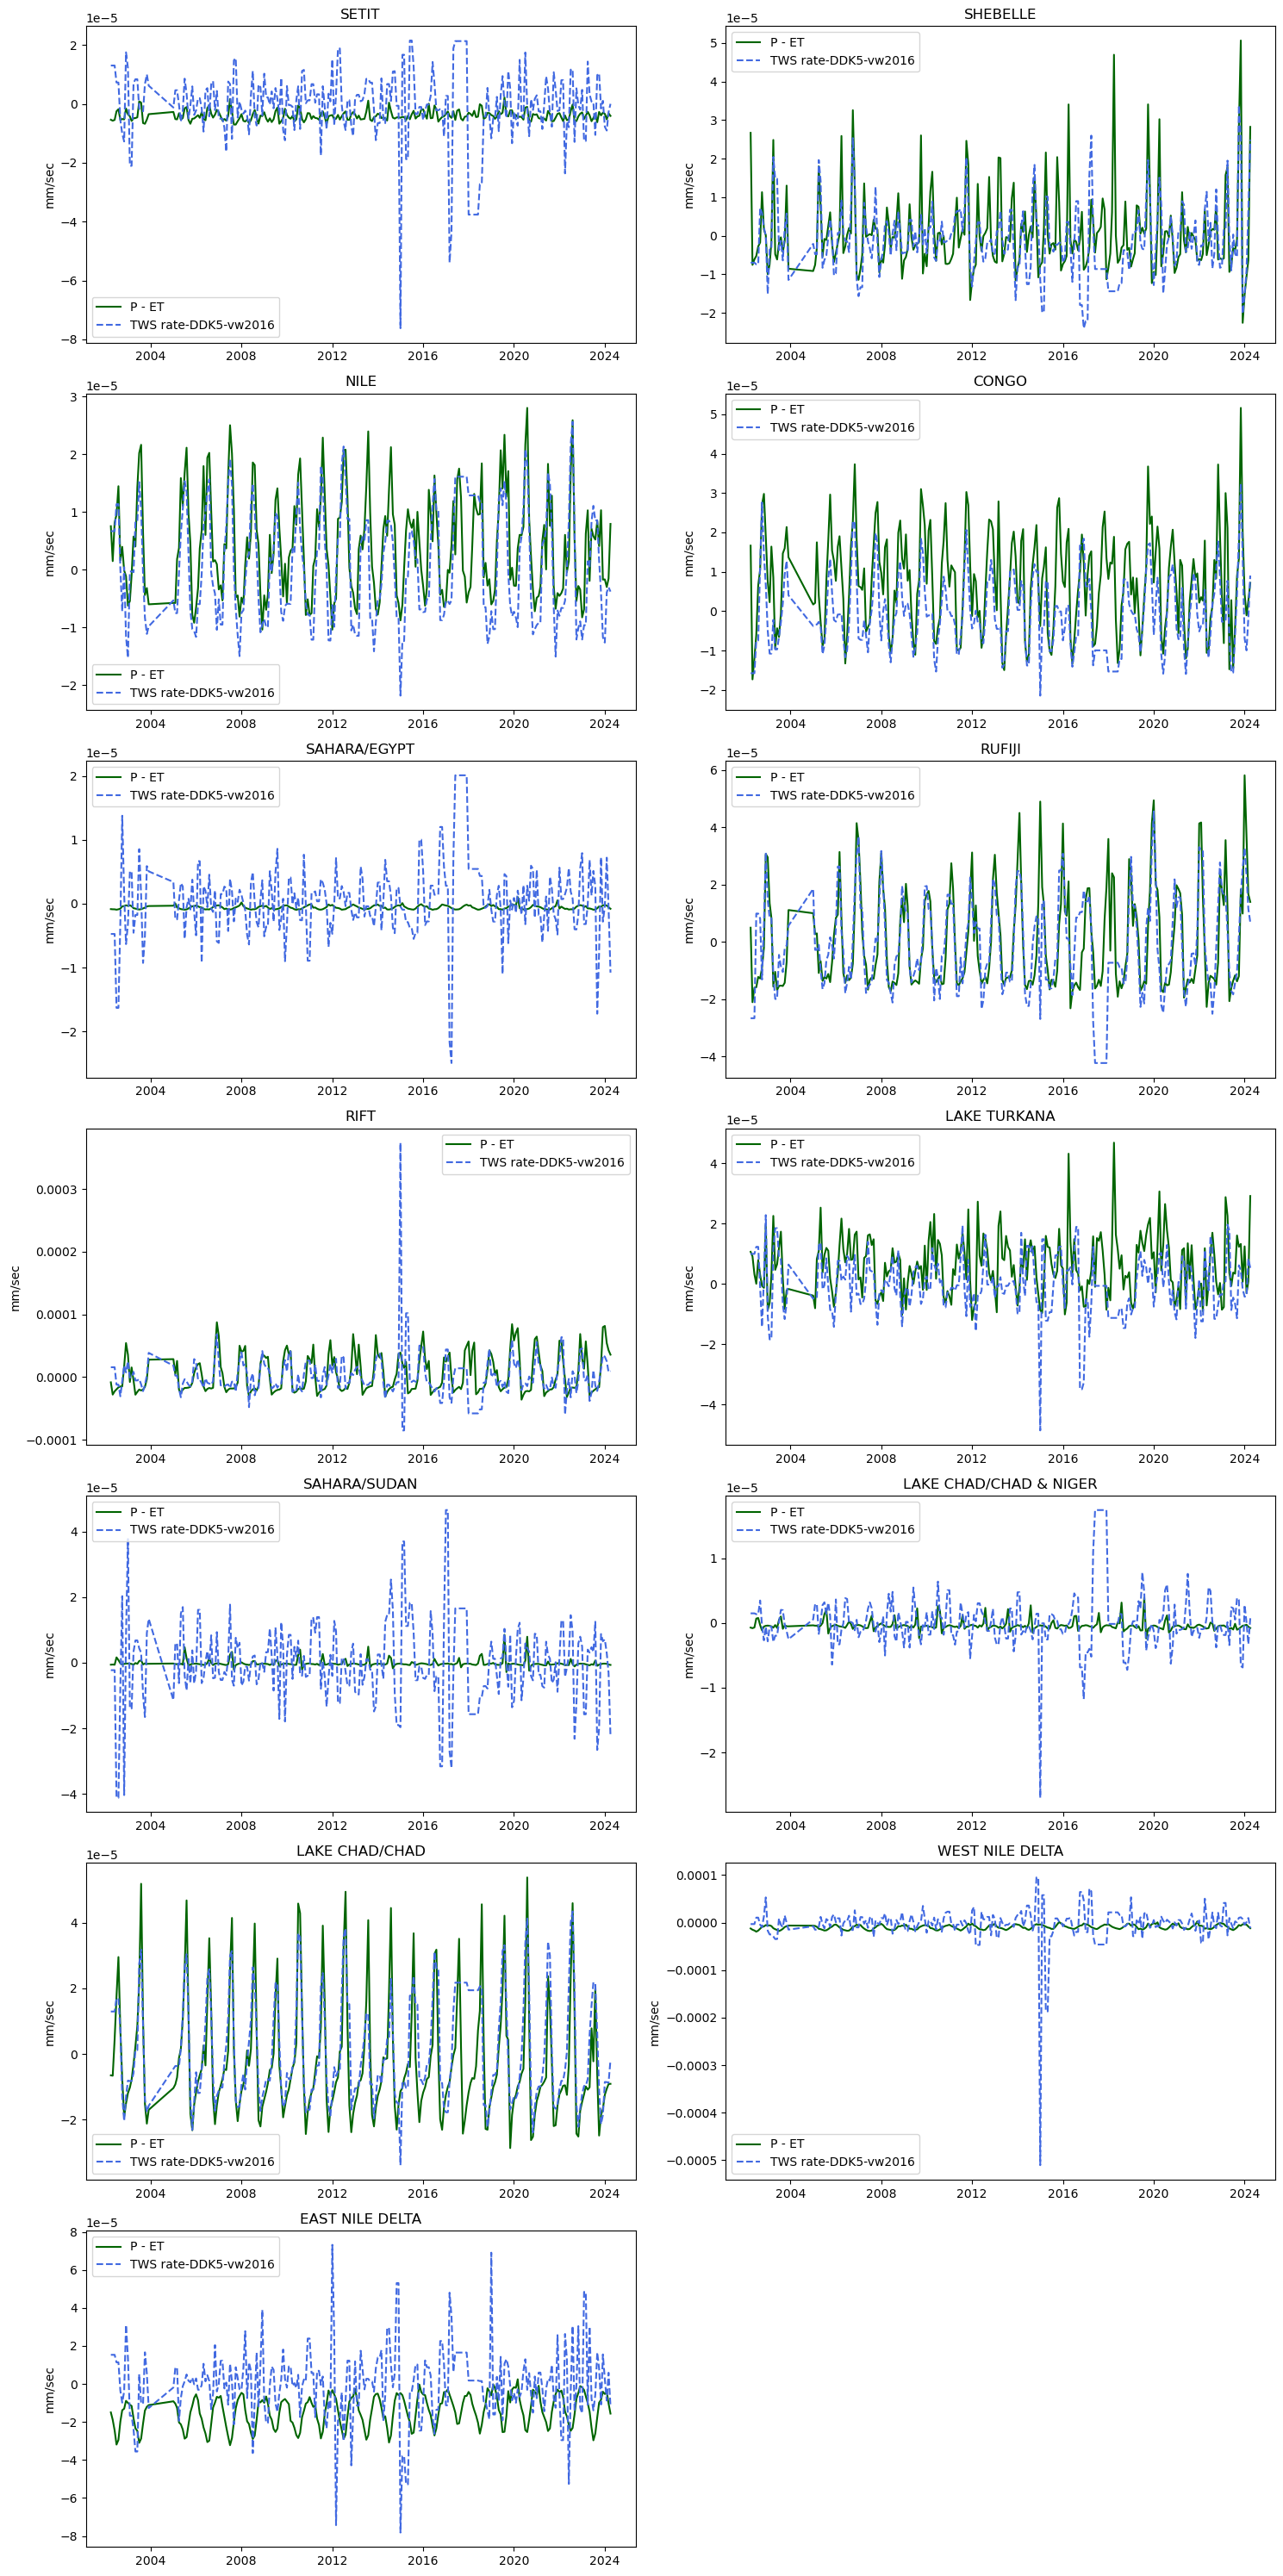

In [15]:
plot_waterflux_timeseries(ds_flux,dsdtbasinav.difft_vw2016,casestudy_hof)